# Analisis de Sentimientos en reseñas de canciones digitales



## Librerias

In [153]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
import spacy
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")
nlp = spacy.load("en_core_web_sm")
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jhonattan.reales/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Datos

In [2]:
# Descargamos el conjunto de reseñas desde nuestro repositorio
# !wget -O Digital_Music_5.json https://raw.githubusercontent.com/Can0land/NLP-Laboratory/refs/heads/main/Digital_Music_5.json

Cargamos el dataset de reseñas, teniendo en cuenta que es un archivo json

In [3]:
df = pd.read_json("./Digital_music_5.json", lines=True)
df.head(3)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,3.0,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN


Eliminamos columnas que no son necesarias para nuestro analisis de sentimientos

In [4]:
df_music = df.drop(
    [
        "reviewTime",
        "unixReviewTime",
        "reviewerID",
        "image",
        "asin",
        "reviewerName",
        "verified",
    ],
    axis=1,
)
df_music.sample(10)

,overall,vote,style,reviewText,summary
77323,5,NaN,{'Format:': ' MP3 Music'},Not a bible thumper but this is a winner.,Great female vocal
72015,5,NaN,{'Format:': ' MP3 Music'},Amazing song! I am always looking for a good s...,General review
30201,4,NaN,{'Format:': ' MP3 Music'},I think it is a good song but you will have to...,A Good Song
56714,5,NaN,{'Format:': ' MP3 Music'},Great song!,Five Stars
20579,4,NaN,NaN,has a lot of hits. good collection.,good collection.
49912,5,NaN,{'Format:': ' MP3 Music'},Good old tune,Five Stars
91924,5,NaN,{'Format:': ' MP3 Music'},Great song.,Five Stars
79207,5,NaN,{'Format:': ' MP3 Music'},Such a perfect song. Forgiveness is one of the...,Five Stars
49793,5,NaN,{'Format:': ' MP3 Music'},Whenever I miss running the boardwalk in Wildw...,Wildwood boardwalk in the winter.
37752,5,NaN,{'Format:': ' MP3 Music'},One of my favorite songs from her. She has a ...,Thank You


Nuestra tabla de reseñas ahora cuenta con las siguientes 5 columnas:

- overall: calificación general del producto (1-5)
- vote: calificación del comentario por parte de otros usuarios
- style: estilo del producto
- reviewText: texto de la reseña
- summary: resumen de la reseña

### Limpieza de datos
Verificamos la calidad de las columnas, y limpiamos los datos

In [5]:
df_music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169781 entries, 0 to 169780
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     169781 non-null  int64  
 1   vote        7611 non-null    float64
 2   style       157989 non-null  object 
 3   reviewText  169623 non-null  object 
 4   summary     169745 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 6.5+ MB


A continuación, aplicaremos algunos pasos de limpieza

In [6]:
# Eliminamos todas las filas con valores nulos en las columnas style y revieText
df_music = df_music.dropna(subset=["style", "reviewText"])

# Modificamos la columna style para que solo tengas valores tipo texto, sin diccionario
df_music["style"] = df_music["style"].apply(
    lambda x: x.get("Format:") if isinstance(x, dict) else None
)
# A la columna vote, los valores nulos los cambiamos por 0
df_music["vote"] = df_music["vote"].fillna(0)

# las columnas tipo texto, le cambiamos las mayusculas por minusculas y le quitamos espamos en blanco al princpio o al final
df_music["reviewText"] = df_music["reviewText"].str.lower().str.strip()
df_music["summary"] = df_music["summary"].str.lower().str.strip()

In [7]:
df_music.sample(2)

,overall,vote,style,reviewText,summary
126832,4,0.0,MP3 Music,clever song,four stars
166505,5,0.0,MP3 Music,great song,those english boys


## EDA
Realizar un EDA para entender el comportamiento y posibles valores de cada variable.


### Variables no tipo texto

In [8]:
df_music.describe()

,overall,vote
count,157835.000000,157835.000000
mean,4.707840,0.374473
std,0.701844,4.417204
min,1.000000,0.000000
25%,5.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,461.000000


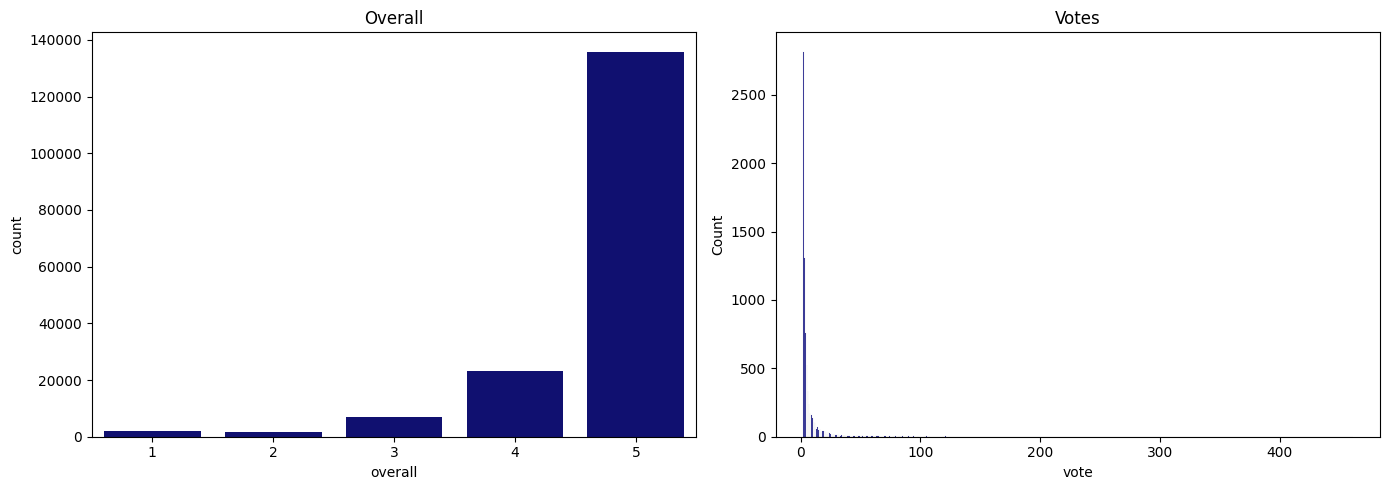

In [9]:
# Graficamos el conteo de las puntuaciones y los votos de cada reseña
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=df, x="overall", color="navy", ax=axes[0])
axes[0].set_title("Overall")

sns.histplot(data=df, x="vote", color="navy", ax=axes[1])
axes[1].set_title("Votes")

plt.tight_layout()
plt.show()

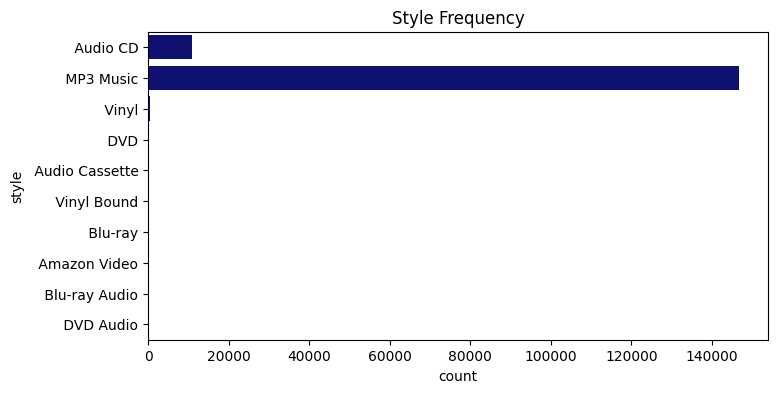

In [10]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_music, y="style", color="navy")
plt.title("Style Frequency")
plt.show()

notas:

In [72]:
# Escogeremos al azar el 5% de las reseñas con overall iguales a 5
# el 30% de las reseñas con overall iguales a 3 o 4
# y el 100% de las reseñas 1 o 2 para tener un dataset balanceado
positive_reviews = df_music[df_music["overall"] == 5].sample(frac=0.05, random_state=15)
neutral_reviews = df_music[df_music["overall"].isin([3, 4])].sample(
    frac=0.3, random_state=15
)
negative_reviews = df_music[df_music["overall"] < 3]

# Unimos en un solo dataframe las reseñas positivas, neutrales y negativas
balanced_df = pd.concat([positive_reviews, neutral_reviews, negative_reviews])

# seleccionamos 10000 reseñas al azar del dataframe balanceado para trabajar con un dataset más pequeño
balanced_df = balanced_df.sample(n=10000, random_state=15)

In [73]:
balanced_df["overall"].value_counts()

overall
4    3537
5    3483
1    1094
3    1021
2     865
Name: count, dtype: int64

In [74]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 169110 to 127228
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   overall     10000 non-null  int64  
 1   vote        10000 non-null  float64
 2   style       10000 non-null  object 
 3   reviewText  10000 non-null  object 
 4   summary     9999 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 468.8+ KB


### Variables tipo texto

De cada variable con textos (principalmente reviewText), obtendremos:
- El numero de tokens (no espacios ni puntuaciones) y luego graficaremos dicha distribución de manera univariada y bivariada junto a la puntuación de la reseña
- El numero de sentencias y graficamos.
- Graficaremos una nube de  palabras para determinar las palabras mas frecuentes, tanto a nivel general, como cruzado con la puntuación.

#### Numero de Tokens

In [76]:
# Función para contar el número de tokens alfanuméricos en una oración sin contar espacios ni puntuaciones
def count_alphanumeric_tokens(sentence):
    doc = nlp(str(sentence))
    t_vector = [t for t in doc if not t.is_punct and not t.is_space]
    return len(t_vector)

In [77]:
temp_df = balanced_df.copy()
temp_df["review_tokens"] = temp_df["reviewText"].apply(count_alphanumeric_tokens)
temp_df["summary_tokens"] = temp_df["summary"].apply(count_alphanumeric_tokens)

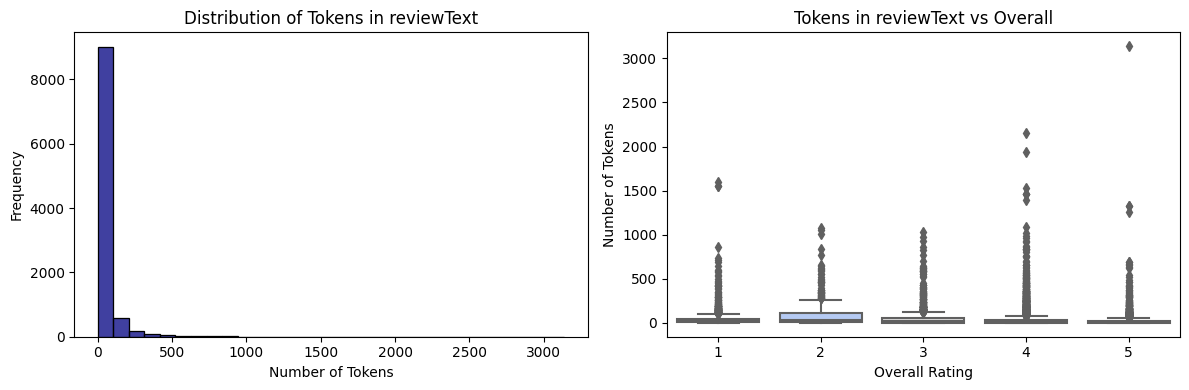

In [78]:
# Graficamos la distribución de tokens en reviewText, univariado y vs overall
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(temp_df["review_tokens"], color="navy", bins=30)
plt.title("Distribution of Tokens in reviewText")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.boxplot(x="overall", y="review_tokens", data=temp_df, palette="coolwarm")
plt.title("Tokens in reviewText vs Overall")
plt.xlabel("Overall Rating")
plt.ylabel("Number of Tokens")

plt.tight_layout()
plt.show()

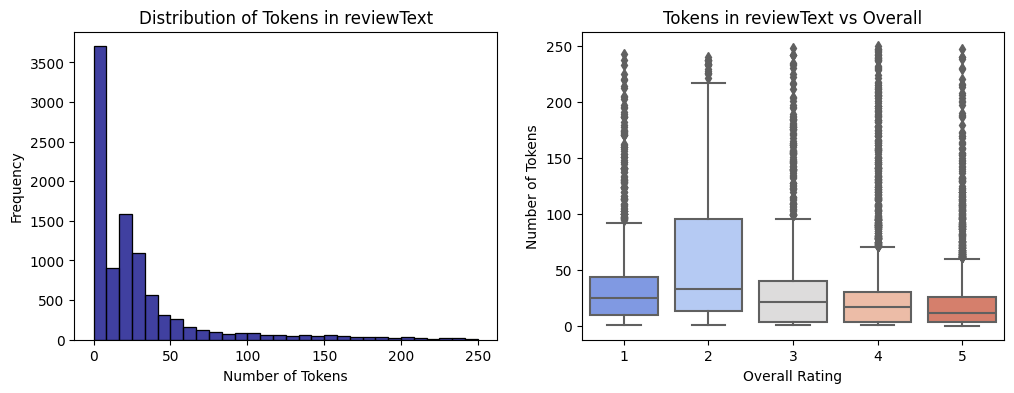

In [81]:
# Graficamos la misma grafica pero solo las reseñas con maximo 250 tokens para ver mejor la distribucion
plt.figure(figsize=(12, 4))

tmp_plot = temp_df[temp_df["review_tokens"] <= 250]

plt.subplot(1, 2, 1)
sns.histplot(tmp_plot["review_tokens"], color="navy", bins=30)
plt.title("Distribution of Tokens in reviewText")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.boxplot(x="overall", y="review_tokens", data=tmp_plot, palette="coolwarm")
plt.title("Tokens in reviewText vs Overall")
plt.xlabel("Overall Rating")
plt.ylabel("Number of Tokens")

# plt.tight_layout()
plt.show()

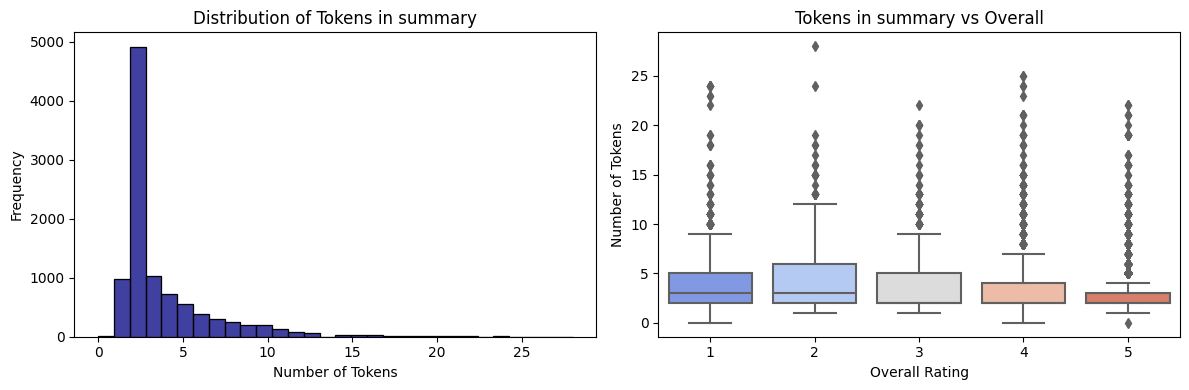

In [83]:
# Ahora, graficamos la distribución de tokens en summary, univariado y vs overall
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(temp_df["summary_tokens"], color="navy", bins=30)
plt.title("Distribution of Tokens in summary")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.boxplot(x="overall", y="summary_tokens", data=temp_df, palette="coolwarm")
plt.title("Tokens in summary vs Overall")
plt.xlabel("Overall Rating")
plt.ylabel("Number of Tokens")

plt.tight_layout()
plt.show()

#### Numero de sentencias

In [84]:
# Función para contar el número de sentencias en cada reseña
def count_sentences(text):
    doc = nlp(str(text))
    return len(list(doc.sents))

In [85]:
temp_df["review_sentences"] = temp_df["reviewText"].apply(count_sentences)
temp_df["summary_sentences"] = temp_df["summary"].apply(count_sentences)

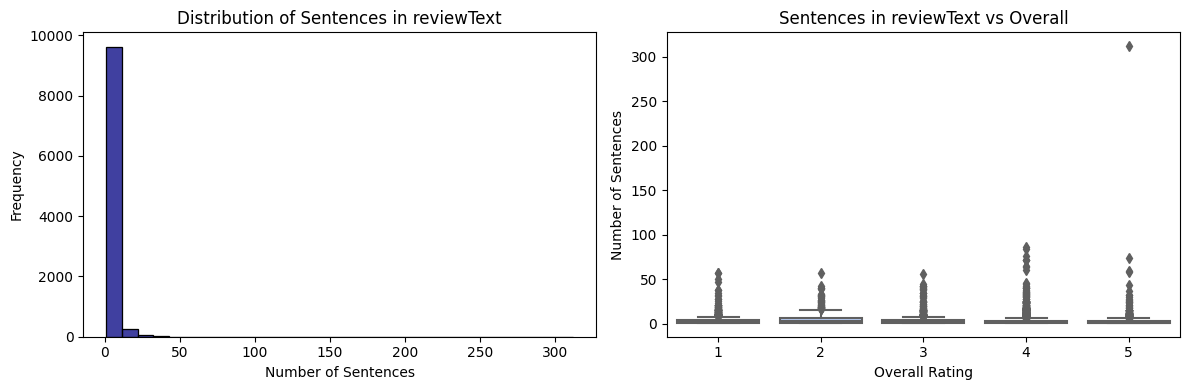

In [87]:
# Graficamos la distribución del numero de sentencias en reviewText, univariado y vs overall
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(temp_df["review_sentences"], color="navy", bins=30)
plt.title("Distribution of Sentences in reviewText")
plt.xlabel("Number of Sentences")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.boxplot(x="overall", y="review_sentences", data=temp_df, palette="coolwarm")
plt.title("Sentences in reviewText vs Overall")
plt.xlabel("Overall Rating")
plt.ylabel("Number of Sentences")

plt.tight_layout()
plt.show()

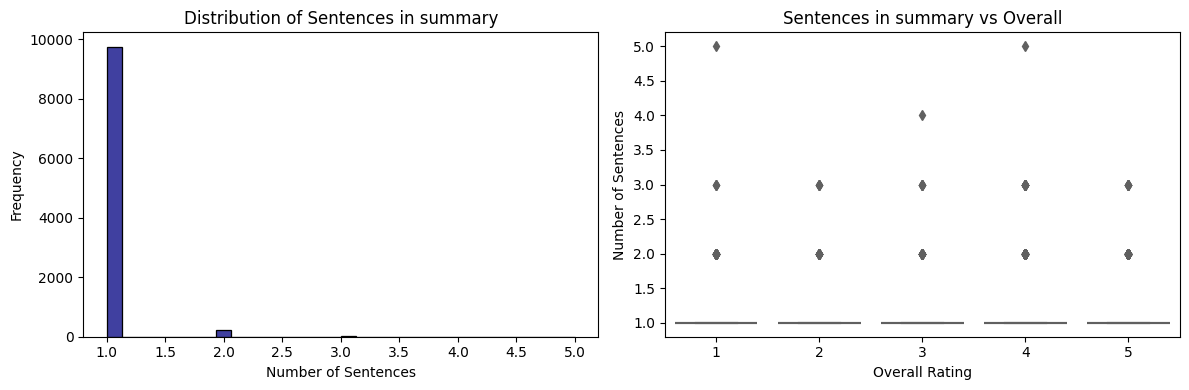

In [88]:
# Graficamos a distribución del numero de sentencias en summary, univariado y vs overall
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(temp_df["summary_sentences"], color="navy", bins=30)
plt.title("Distribution of Sentences in summary")
plt.xlabel("Number of Sentences")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.boxplot(x="overall", y="summary_sentences", data=temp_df, palette="coolwarm")
plt.title("Sentences in summary vs Overall")
plt.xlabel("Overall Rating")
plt.ylabel("Number of Sentences")

plt.tight_layout()
plt.show()

#### Wordclouds

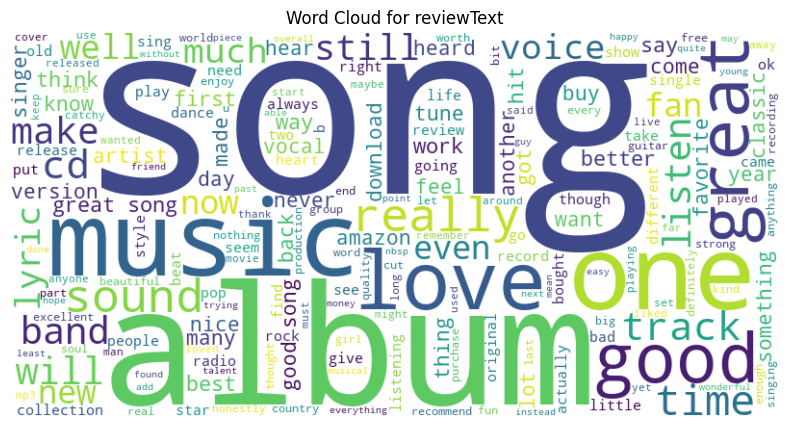

In [61]:
# Nube de palabras general para reviewText
all_text = " ".join(balanced_df["reviewText"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    all_text
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for reviewText")
plt.show()

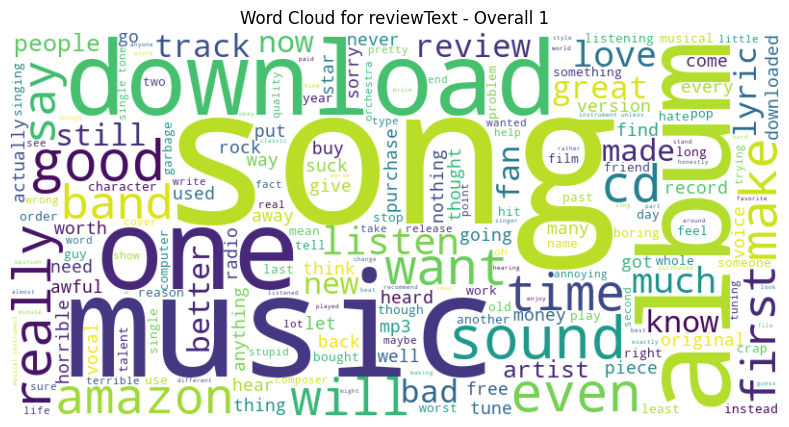

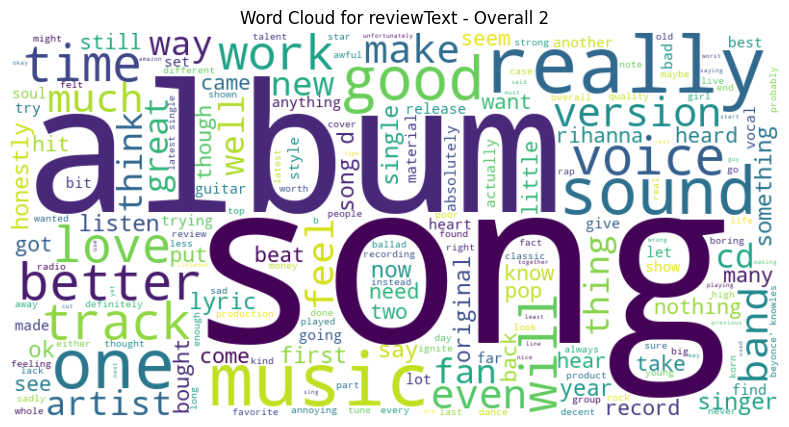

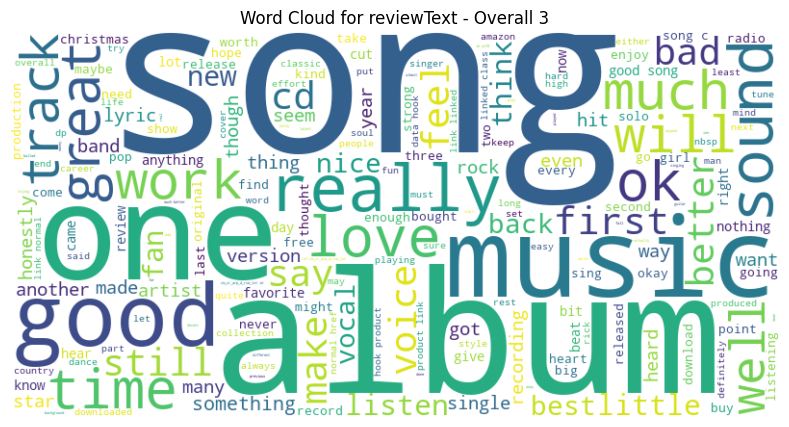

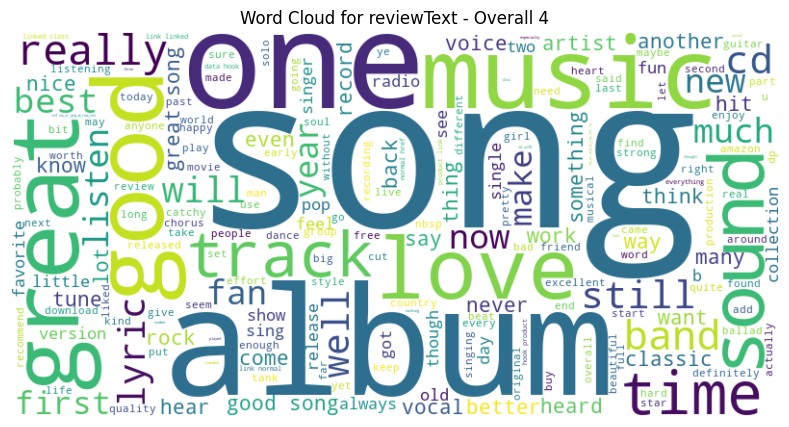

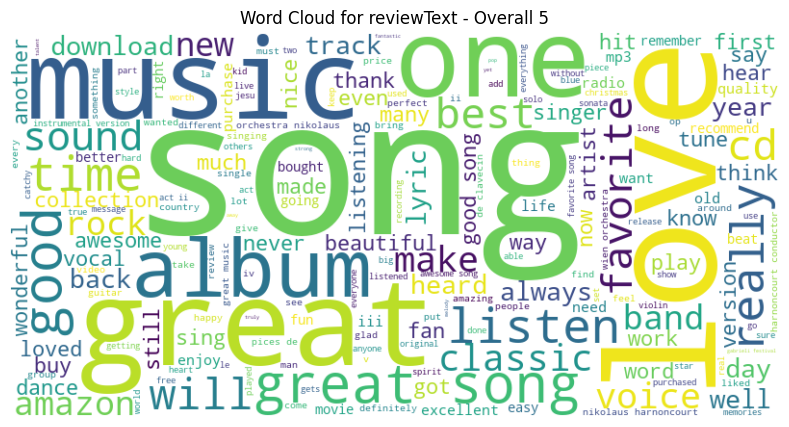

In [70]:
# Nube de palabras de reviewText por cada nivel de overall
overall_levels = sorted(balanced_df["overall"].unique())
for i, level in enumerate(overall_levels):

    plt.figure(figsize=(15, 5))
    # plt.subplot(len(overall_levels), 1, i + 1)
    level_text = " ".join(
        balanced_df[balanced_df["overall"] == level]["reviewText"].astype(str)
    )

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        level_text
    )
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for reviewText - Overall {level}")
    plt.show()

# plt.tight_layout()

## Pre-procesamiento

A continuación, realizaremos unos ultimos pasos antes de realizar el analisis de sentimiento en el texto de las reseñas.
- Eliminaremos reseñas con mas de 250 tokens (textos muy largos que aparentan ser listado de las canciones dentro de los productos).
- Eliminaremos URLs, HTML, espacios

De esta manera dejaremos nuestro dataframe de reseñas listo para aplicarle modelos que intenten cuantificar el sentimiento positivo o negativo de cada reseña

In [97]:
def clean_step(text):
    text = str(text)
    text = re.sub(r"http\S+|www\.\S+", " ", text)  # URLs
    text = re.sub(r"<.*?>", " ", text)  # HTML
    text = re.sub(r"\s+", " ", text).strip()  # espacios
    return text

In [112]:
# añadimos las columnas de tokens y sentencias de temp_df
df_pre = balanced_df.copy()
df_pre[temp_df.columns[-4:]] = temp_df.iloc[:, -4:]

# Eliminar las reseñas con mas de 250 tokens en reviewText para tener un dataset más limpio y balanceado
df_pre = df_pre[df_pre["review_tokens"] <= 250]

# Limpieza final de reviewText y summary para el análisis de sentimiento
df_pre["reviewText"] = df_pre["reviewText"].apply(clean_step)
df_pre["summary"] = df_pre["summary"].apply(clean_step)

## Analisis de sentimiento

Llevaremos a cabo dos aproximaciones para cuantificar el sentimiento de las reseñas que tenemos en el estudio:
- Un modelo de la libreria nltk (VADER)
- Un modelo en base a transformers (BERT-like)

In [114]:
df_sentiment = df_pre[["reviewText", "summary", "overall"]].copy()

### VARD model

In [ ]:
# Ahora, aplicamos el análisis de sentimiento usando VADER, tanto para el texto de la reseña como el summary.
# Consideramos una reseña como positiva si el compound score es mayor a 0, negativa si es menor o igual a 0

sid = SentimentIntensityAnalyzer()

# sentimiento de reviewText
df_sentiment["sentiment_score_text"] = df_sentiment["reviewText"].apply(
    lambda x: sid.polarity_scores(x)["compound"]
)

df_sentiment["sentiment_text_vader"] = df_sentiment["sentiment_score_text"].apply(
    lambda x: "positive" if x > 0 else "negative"
)

# sentimiento de summary
df_sentiment["sentiment_score_summary"] = df_sentiment["summary"].apply(
    lambda x: sid.polarity_scores(x)["compound"]
)

df_sentiment["sentiment_summary_vader"] = df_sentiment["sentiment_score_summary"].apply(
    lambda x: "positive" if x > 0 else "negative"
)

# borrar columnas de score
df_sentiment = df_sentiment.drop(
    ["sentiment_score_text", "sentiment_score_summary"], axis=1
)

### Modelo tipo BERT

In [ ]:
# Utilizamos un modelo de Hugging Face basado en transformers para el análisis de sentimiento
sentiment_pipeline = pipeline(
    "sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english"
)


# ------
# Creamos una función para aplicar el análisis de sentimiento con transformers en batches para evitar problemas de memoria
def get_transformer_sentiment(texts, batch_size=32):
    results = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        preds = sentiment_pipeline(batch)
        results.extend(preds)

    return results

In [ ]:
# Utilizamos la función para obtener los resultados del análisis de sentimiento con transformers en reviewText
preds_text = get_transformer_sentiment(df_sentiment["reviewText"].tolist())
df_sentiment["sentiment_text_transformer"] = [p["label"].lower() for p in preds_text]

# Ahora, aplicamos el análisis de sentimiento con transformers en summary
preds_summary = get_transformer_sentiment(df_sentiment["summary"].tolist())
df_sentiment["sentiment_summary_transformer"] = [
    p["label"].lower() for p in preds_summary
]

### Modelo enfoque ML: TF-IDF + stacking modelos ML
En esta tercera aproximación, intentaremos determinar el sentimiento del texto, utilizando variables semanticas y estructurales de las reseñas, junto a un modelo de aprendizaje supervisado. Además, utilizaremos la columna overall para construir una variable target binaria.

Este enfoque lo dividiremos en 2 fases:
- Entrenamiento y predicción del modelo de clasificación binario utilizando matriz dispersa de TF-IDF
- Utilizando el score predecido por la regresión logistica (score_log), se entrena otro modelo tipo Random Forest utilizando como variables predictoras el score_log y las otras variables creadas en pasos anteriores.

**NOTA: Se utiliza predicciones con validación cruzada para evitar data leakage, asi realizamos predicciones en observaciones con modelos que no conocen esos datos de antemano.**

In [159]:
# Función para entrenar una regresión logística y obtener las probabilidades de la clase positiva.
# Usando predicciones con validación cruzada para evitar sobreajuste


def train_logreg_get_score(X, y, *, random_state=100, return_model=False):
    model = LogisticRegression(
        solver="saga", max_iter=2000, n_jobs=-1, random_state=random_state
    )

    # Probabilidad clase positiva
    scores = cross_val_predict(model, X, y, cv=5, method="predict_proba")[:, 1]

    if return_model:
        return scores, model

    return scores

In [160]:
# Función para entrenar un modelo de clasificación Random Forest
# y devuelve labels predichos por observación usando CV (out-of-fold).


def train_rf_get_labels(
    X,
    y,
    *,
    cv=5,
    positive_label=1,
    negative_label=0,
    label_map=None,
    random_state=100,
    return_model=False,
    **rf_params
):

    if label_map is None:
        label_map = {negative_label: "negative", positive_label: "positive"}

    # Si X no es DataFrame, lo convertimos
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    # Detectar tipos de columnas
    numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
    categorical_cols = X.select_dtypes(include=["object", "category"]).columns

    # Preprocesador
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ]
    )

    # Modelo
    rf = RandomForestClassifier(random_state=random_state, n_jobs=-1, **rf_params)

    # Pipeline completo
    pipeline = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", rf),
        ]
    )

    # Predicción out-of-fold
    pred_class = cross_val_predict(pipeline, X, y, cv=cv, method="predict")

    pred_labels_str = np.vectorize(label_map.get)(pred_class)

    if return_model:
        return pred_labels_str, pipeline

    return pred_labels_str

In [161]:
df_sentiment_ml = df_pre.copy()

# variable overall binaria para entrenar el modelo supervisado
# consideramos como negativo si overall es 1, 2 o 3 y positivo si es 4 o 5
df_sentiment_ml["target_bin"] = df_sentiment_ml["overall"].apply(
    lambda x: 0 if x <= 3 else 1
)

# ------
# utilizamos TF-IDF para vectorizar el texto de reviewText y summary
tfidf = TfidfVectorizer(
    max_features=5000, ngram_range=(1, 2), stop_words="english"  # si es inglés
)

X_text = tfidf.fit_transform(df_sentiment_ml["reviewText"].fillna(""))
X_summary = tfidf.fit_transform(df_sentiment_ml["summary"].fillna(""))

# -----
## Realizamos una primera predicción usando una
## regresión logistica entrenada sobre la matrix dispersa de TF-IDF

# reviewText
score_log_text = train_logreg_get_score(
    X_text, df_sentiment_ml["target_bin"], return_model=False
)

df_sentiment_ml["score_log_text"] = score_log_text

# summary
score_log_summary = train_logreg_get_score(
    X_summary, df_sentiment_ml["target_bin"], return_model=False
)
df_sentiment_ml["score_log_summary"] = score_log_summary

In [162]:
## A continuación, utilizamos el score de la regresion logistica junto a otras variables de cada
## reseña para entrenar un modelo random forest y obtener un nuevo score de sentimiento más robusto.
## Este score se basará en la combinación de las predicciones del modelo supervisado junto con otras características
## como el número de tokens, número de sentencias, etc.

df_ml_tmp = df_sentiment_ml.copy()
df_ml_tmp = df_ml_tmp.dropna(subset=["score_log_text", "score_log_summary"])

# Eliminamos las columnas que no se usarán para entrenar el modelo supervisado
df_ml_tmp.drop(["reviewText", "summary", "overall", "target_bin"], axis=1, inplace=True)

# Variable objetivo
y = df_sentiment_ml.loc[df_ml_tmp.index, "target_bin"]

# Características para el modelo supervisado de reviewText
X_text = df_ml_tmp.drop(["score_log_summary"], axis=1)

# Características para el modelo supervisado de summary
X_summary = df_ml_tmp.drop(["score_log_text"], axis=1)

# --------
## Generamos una ultima predicción con las covariables elegidas y el score de la regresión logistica

# reviewText
predict_ml_text = train_rf_get_labels(X_text, y, positive_label=1, return_model=False)

df_sentiment_ml["sentiment_text_ml"] = predict_ml_text

# summary
predict_ml_summary = train_rf_get_labels(
    X_summary, y, positive_label=1, return_model=False
)
df_sentiment_ml["sentiment_summary_ml"] = predict_ml_summary

In [165]:
# Unimos los resultados del análisis de sentimiento con VADER, transformers y el modelo supervisado en un solo dataframe para comparar los resultados
df_sentiment_final = pd.concat(
    [df_sentiment, df_sentiment_ml[["sentiment_text_ml", "sentiment_summary_ml"]]],
    axis=1,
)

In [166]:
df_sentiment_final

,reviewText,summary,overall,sentiment_score_text,sentiment_text_vader,sentiment_score_summary,sentiment_summary_vader,sentiment_score_text_transformer,sentiment_text_transformer,sentiment_score_summary_transformer,sentiment_summary_transformer,sentiment_text_ml,sentiment_summary_ml
169110,dope,five stars,5,0.0000,neutral,0.0000,neutral,0.943412,NEGATIVE,0.999009,POSITIVE,negative,positive
141174,a sentimental and sappy song. but sweet if tha...,do you even need a review?,5,0.9517,positive,0.0000,neutral,0.899016,NEGATIVE,0.993773,NEGATIVE,negative,positive
155355,i would not mind having my husband's hands mov...,hands country style,4,0.4753,positive,0.0000,neutral,0.981537,POSITIVE,0.792444,POSITIVE,positive,positive
82874,these young men are amazing for the depth that...,totally enchanging,5,0.9371,positive,0.0000,neutral,0.999884,POSITIVE,0.999464,POSITIVE,positive,positive
112255,i never heard or saw this group outside of ama...,i'm looking forward to more music from them,1,0.4885,positive,0.0000,neutral,0.996504,NEGATIVE,0.999654,POSITIVE,positive,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109919,great product and i was very happy with it!,very nice!,5,0.8550,positive,0.5244,positive,0.999880,POSITIVE,0.999860,POSITIVE,positive,positive
52237,i did a lot of searching....amazon had it. gre...,great old tune!,5,0.9633,positive,0.6588,positive,0.999859,POSITIVE,0.999873,POSITIVE,positive,positive
51062,i like any version of hallelujah and this is a...,good version,4,0.8943,positive,0.4404,positive,0.999878,POSITIVE,0.999837,POSITIVE,positive,positive
111598,"love this song, says what my heart longs for d...",even so come....,5,0.6369,positive,0.0000,neutral,0.999865,POSITIVE,0.938183,POSITIVE,positive,negative


## Analisis de resultados

## Conclusion